In [63]:
!pip freeze | grep plotnine

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
plotnine==0.3.0


In [52]:
import utils
import pandas as pd
import expert_factory
import numpy as np

In [53]:
def calcula_verossimilhanca(num_experts, y_true, output_experts, output_gating):
    py = np.zeros(shape=(len(y_true),num_experts))
    for expert in range(0,num_experts):
        for index,y in enumerate(y_true):
            #calcula a diff entre o real e o que o cada expert previu
            #diff = Ytr(j,:)-Yaux(j,:);
            diff = y - output_experts[index,expert]
            #Py(j,i)=exp(-diff*diff'/(2*var(i)));   
            py[index,expert] = np.exp(-np.dot(diff, diff.T) / (2))
    # Likelihood= sum(log(sum(Yg.*Py,2)));
    #haux = Yg.*Py;
    haux = np.multiply(output_gating, py)
    likelihood = np.sum(np.log(np.sum(haux,axis=1)))
    return likelihood,haux       

In [54]:
def output_final(X, gating_network, all_experts):
    #Calcula saida do gating
    gating_output = gating_network.feedforward(X)[-1]
    experts_outputs = []
    #calcula saida do experts
    for exp_net in all_experts:
        experts_outputs.append(exp_net.feedforward(X)[-1].tolist())
    #retorna o melhor expert como saida
    final_output = []
    for index_gate, result in enumerate(np.argmax(gating_output,axis=1)):
        final_output.append(experts_outputs[result][index_gate])
    return final_output
        

def maximiza_gating(gating_network, X, y, X_val, y_val,h):
    gating_network.train(X, y,
                         X_val, y_val,
                         numero_max_erro_val=10,
                         h_tipo='gat',
                         h=h,
                         plot=False)
    
def maximiza_expert(expert_network, X, y, X_val, y_val,h):
    expert_network.train(X, y,
                         X_val, y_val,
                         numero_max_erro_val=10,
                         h_tipo='exp',
                         h=h,
                         plot=False)

In [55]:
#Lendo o dado
df = pd.read_csv('data/treinamento-1.txt', header=None)

#normalizando o dado
df = utils.normalize_data(df)
num_lags = 15

#criando Lag
lagged_data = utils.create_lag(df, num_lags)
lagged_data = lagged_data.reset_index(drop=True)

X = lagged_data.drop(['y'],axis=1)
y = lagged_data['y']

#Criando conjunto de dados
fracao_dados_para_treino = 0.7
fracao_dados_para_teste = 0.2
X_train,y_train,X_test,y_test,X_val,y_val = utils.treino_teste_validacao(X,y, frac_train=fracao_dados_para_treino, frac_test=fracao_dados_para_teste)

Tamanho total 985
Tamanho treino 689
Tamanho teste 197
Tamanho validacao 99


In [56]:

all_ne = X_train.shape[1]
## Vamos criar alguns experts
all_experts = []
exp1 = expert_factory.Expert(ne=all_ne,nh=2,ns=1,g_h='sigmoid',g_o='sigmoid',max_epoch=10000, alpha=0.015)
exp2 = expert_factory.Expert(ne=all_ne,nh=4,ns=1,g_h='sigmoid',g_o='sigmoid',max_epoch=10000, alpha=0.025)
exp3 = expert_factory.Expert(ne=all_ne,nh=3,ns=1,g_h='sigmoid',g_o='sigmoid',max_epoch=10000, alpha=0.055)
exp4 = expert_factory.Expert(ne=all_ne,nh=3,ns=1,g_h='sigmoid',g_o='sigmoid',max_epoch=20000, alpha=0.3)
exp5 = expert_factory.Expert(ne=all_ne,nh=4,ns=1,g_h='tan_h',g_o='sigmoid',max_epoch=10000, alpha=0.6)

all_experts.append(exp1)
all_experts.append(exp2)
all_experts.append(exp3)
all_experts.append(exp4)
all_experts.append(exp5)


num_experts = len(all_experts)

In [57]:
#Criando rede gating   
gating_ne = X_train.shape[1]
gating_nh = 5
gating_ns = num_experts
gating_network = expert_factory.Expert(gating_ne,gating_nh,gating_ns, g_h='sigmoid', g_o='softmax',max_epoch=10000, alpha=0.02)

In [58]:
likelihood = 0
old_likelihood = -np.inf
best_erro_val = np.inf
count_erro_val = 0
iters = 0
max_iters = 3000
all_loss = []
all_likeli = []
while abs(likelihood-old_likelihood) > 1e-3 and iters < max_iters:
    iters += 1
    print("Epoca: {}".format(iters))
    #calcula a saida para cada rede
    #A funcao retorna 4 variaveis, queremos apenas a ultima que representa o output (por isso o [-1])
    output_gating = gating_network.feedforward(X_train)[-1]
    output_experts = np.matrix([np.ravel(expert.feedforward(X_train)[-1]).tolist() for expert in all_experts]).T
    #Agora que temos a saida comecamos com a funcao de EM
    old_likelihood = likelihood
    #Passo E (Expectation)
    #Com os parametros atuais calculamos calculamos a 'expectation' posterior para cada expert
    likelihood,haux_train = calcula_verossimilhanca(num_experts, y_train, output_experts, output_gating)
    #likelihood_val,haux_val = calcula_verossimilhanca(num_experts, y_train, output_experts, output_gating, matriz_covariancia)
    #h = haux./(sum(haux,2)*ones(1,m));
    h = np.divide(haux_train, np.dot(np.sum(haux_train,axis=1).reshape(haux_train.shape[0],1),np.ones((1,num_experts))))
    #Passo M (Maximizacao)
    maximiza_gating(gating_network, X_train, y_train, X_val, y_val,h)
    #Itera por cada expert o treinando com seu respectivo h
    for exp_index, expert in enumerate(all_experts):
        output_individual_exp = []
        for item in h[:,0]:
            output_individual_exp.append([item])
        maximiza_expert(expert, X_train, y_train, X_val, y_val,h=output_individual_exp)
    
    saida_final = output_final(X_train, gating_network, all_experts)
    erro = saida_final - y_train 
    loss = np.square(erro).mean()
    all_loss.append(loss)
    all_likeli.append(likelihood)
    print("MSE treino: {}".format(loss))
    
#     #Acompanha no set de validacao
#     saida_validacao = output_final(X_val, gating_network, all_experts)
#     erro_val = saida_validacao - y_val
#     loss_val = np.square(erro_val).mean()
#     if loss_val < best_erro_val:
#         #reseta contagem erros
#         count_erro_val = 0
#         #Guarda melhores redes
#         best_erro_val = loss_val
#         best_exp = all_experts
#         best_gating = gating_network
#     else:
#         count_erro_val += 1
#         if count_erro_val > 50:
#             print("Treinamento encerrado por erro de validacao")
#             #retorna melhroes redes
#             all_experts = best_exp
#             gating_network = best_gating
#             break
    

Epoca: 1
MSE treino: 0.34275582658660836
Epoca: 2
MSE treino: 0.3654724941481156
Epoca: 3


/home/favoretti/mestrado/data_mining/clods/mixture_of_experts/expert_factory.py:5: RuntimeWarning: overflow encountered in exp
  return (1.) / (1 + np.exp(-x))


MSE treino: 0.3476444439924738
Epoca: 4
MSE treino: 0.336492974004093
Epoca: 5
MSE treino: 0.3634377229014499
Epoca: 6
MSE treino: 0.332307783155602
Epoca: 7
MSE treino: 0.35246259875675223
Epoca: 8
MSE treino: 0.3300784064492191
Epoca: 9
MSE treino: 0.350342195709206
Epoca: 10
MSE treino: 0.3652132494874572
Epoca: 11
MSE treino: 0.35321122161303437
Epoca: 12
MSE treino: 0.3380332582235064
Epoca: 13
MSE treino: 0.17174147897756223
Epoca: 14
MSE treino: 0.30182571354054805
Epoca: 15
MSE treino: 0.3053574972766817
Epoca: 16
MSE treino: 0.27070435286946254
Epoca: 17
MSE treino: 0.1444313213959631
Epoca: 18
MSE treino: 0.13798967275467652
Epoca: 19
MSE treino: 0.13839345364097022
Epoca: 20
MSE treino: 0.13839449568859788
Epoca: 21
MSE treino: 0.13841764825162375
Epoca: 22
MSE treino: 0.13843351951054622
Epoca: 23
MSE treino: 0.13844288407717806
Epoca: 24
MSE treino: 0.13844791340953058
Epoca: 25
MSE treino: 0.13845043424360187
Epoca: 26
MSE treino: 0.13845163460286217
Epoca: 27
MSE treino:

MSE treino: 0.13845261393238703
Epoca: 201
MSE treino: 0.13845261393238703
Epoca: 202
MSE treino: 0.13845261393238703
Epoca: 203
MSE treino: 0.13845261393238703
Epoca: 204
MSE treino: 0.13845261393238703
Epoca: 205
MSE treino: 0.13845261393238703
Epoca: 206
MSE treino: 0.13845261393238703
Epoca: 207
MSE treino: 0.13845261393238703
Epoca: 208
MSE treino: 0.13845261393238703
Epoca: 209
MSE treino: 0.13845261393238703
Epoca: 210
MSE treino: 0.13845261393238703
Epoca: 211
MSE treino: 0.13845261393238703
Epoca: 212
MSE treino: 0.13845261393238703
Epoca: 213
MSE treino: 0.13845261393238703
Epoca: 214
MSE treino: 0.13845261393238703
Epoca: 215
MSE treino: 0.13845261393238703
Epoca: 216
MSE treino: 0.13845261393238703
Epoca: 217
MSE treino: 0.13845261393238703
Epoca: 218
MSE treino: 0.13845261393238703
Epoca: 219
MSE treino: 0.13845261393238703
Epoca: 220
MSE treino: 0.13845261393238703
Epoca: 221
MSE treino: 0.13845261393238703
Epoca: 222
MSE treino: 0.13845261393238703
Epoca: 223
MSE treino:

MSE treino: 0.13845261393238703
Epoca: 393
MSE treino: 0.13845261393238703
Epoca: 394
MSE treino: 0.13845261393238703
Epoca: 395
MSE treino: 0.13845261393238703
Epoca: 396
MSE treino: 0.13845261393238703
Epoca: 397
MSE treino: 0.13845261393238703
Epoca: 398
MSE treino: 0.13845261393238703
Epoca: 399
MSE treino: 0.13845261393238703
Epoca: 400
MSE treino: 0.13845261393238703
Epoca: 401
MSE treino: 0.13845261393238703
Epoca: 402
MSE treino: 0.13845261393238703
Epoca: 403
MSE treino: 0.13845261393238703
Epoca: 404
MSE treino: 0.13845261393238703
Epoca: 405
MSE treino: 0.13845261393238703
Epoca: 406
MSE treino: 0.13845261393238703
Epoca: 407
MSE treino: 0.13845261393238703
Epoca: 408
MSE treino: 0.13845261393238703
Epoca: 409
MSE treino: 0.13845261393238703
Epoca: 410
MSE treino: 0.13845261393238703
Epoca: 411
MSE treino: 0.13845261393238703
Epoca: 412
MSE treino: 0.13845261393238703
Epoca: 413
MSE treino: 0.13845261393238703
Epoca: 414
MSE treino: 0.13845261393238703
Epoca: 415
MSE treino:

MSE treino: 0.13845261393238703
Epoca: 585
MSE treino: 0.13845261393238703
Epoca: 586
MSE treino: 0.13845261393238703
Epoca: 587
MSE treino: 0.13845261393238703
Epoca: 588
MSE treino: 0.13845261393238703
Epoca: 589
MSE treino: 0.13845261393238703
Epoca: 590
MSE treino: 0.13845261393238703
Epoca: 591
MSE treino: 0.13845261393238703
Epoca: 592
MSE treino: 0.13845261393238703
Epoca: 593
MSE treino: 0.13845261393238703
Epoca: 594
MSE treino: 0.13845261393238703
Epoca: 595
MSE treino: 0.13845261393238703
Epoca: 596
MSE treino: 0.13845261393238703
Epoca: 597
MSE treino: 0.13845261393238703
Epoca: 598
MSE treino: 0.13845261393238703
Epoca: 599
MSE treino: 0.13845261393238703
Epoca: 600
MSE treino: 0.13845261393238703
Epoca: 601
MSE treino: 0.13845261393238703
Epoca: 602
MSE treino: 0.13845261393238703
Epoca: 603
MSE treino: 0.13845261393238703
Epoca: 604
MSE treino: 0.13845261393238703
Epoca: 605
MSE treino: 0.13845261393238703
Epoca: 606
MSE treino: 0.13845261393238703
Epoca: 607
MSE treino:

MSE treino: 0.13845261393238703
Epoca: 777
MSE treino: 0.13845261393238703
Epoca: 778
MSE treino: 0.13845261393238703
Epoca: 779
MSE treino: 0.13845261393238703
Epoca: 780
MSE treino: 0.13845261393238703
Epoca: 781
MSE treino: 0.13845261393238703
Epoca: 782
MSE treino: 0.13845261393238703
Epoca: 783
MSE treino: 0.13845261393238703
Epoca: 784
MSE treino: 0.13845261393238703
Epoca: 785
MSE treino: 0.13845261393238703
Epoca: 786
MSE treino: 0.13845261393238703
Epoca: 787
MSE treino: 0.13845261393238703
Epoca: 788
MSE treino: 0.13845261393238703
Epoca: 789
MSE treino: 0.13845261393238703
Epoca: 790
MSE treino: 0.13845261393238703
Epoca: 791
MSE treino: 0.13845261393238703
Epoca: 792
MSE treino: 0.13845261393238703
Epoca: 793
MSE treino: 0.13845261393238703
Epoca: 794
MSE treino: 0.13845261393238703
Epoca: 795
MSE treino: 0.13845261393238703
Epoca: 796
MSE treino: 0.13845261393238703
Epoca: 797
MSE treino: 0.13845261393238703
Epoca: 798
MSE treino: 0.13845261393238703
Epoca: 799
MSE treino:

MSE treino: 0.13845261393238703
Epoca: 968
MSE treino: 0.13845261393238703
Epoca: 969
MSE treino: 0.13845261393238703
Epoca: 970
MSE treino: 0.13845261393238703
Epoca: 971
MSE treino: 0.13845261393238703
Epoca: 972
MSE treino: 0.13845261393238703
Epoca: 973
MSE treino: 0.13845261393238703
Epoca: 974
MSE treino: 0.13845261393238703
Epoca: 975
MSE treino: 0.13845261393238703
Epoca: 976
MSE treino: 0.13845261393238703
Epoca: 977
MSE treino: 0.13845261393238703
Epoca: 978
MSE treino: 0.13845261393238703
Epoca: 979
MSE treino: 0.13845261393238703
Epoca: 980
MSE treino: 0.13845261393238703
Epoca: 981
MSE treino: 0.13845261393238703
Epoca: 982
MSE treino: 0.13845261393238703
Epoca: 983
MSE treino: 0.13845261393238703
Epoca: 984
MSE treino: 0.13845261393238703
Epoca: 985
MSE treino: 0.13845261393238703
Epoca: 986
MSE treino: 0.13845261393238703
Epoca: 987
MSE treino: 0.13845261393238703
Epoca: 988
MSE treino: 0.13845261393238703
Epoca: 989
MSE treino: 0.13845261393238703
Epoca: 990
MSE treino:

MSE treino: 0.13845261393238703
Epoca: 1156
MSE treino: 0.13845261393238703
Epoca: 1157
MSE treino: 0.13845261393238703
Epoca: 1158
MSE treino: 0.13845261393238703
Epoca: 1159
MSE treino: 0.13845261393238703
Epoca: 1160
MSE treino: 0.13845261393238703
Epoca: 1161
MSE treino: 0.13845261393238703
Epoca: 1162
MSE treino: 0.13845261393238703
Epoca: 1163
MSE treino: 0.13845261393238703
Epoca: 1164
MSE treino: 0.13845261393238703
Epoca: 1165
MSE treino: 0.13845261393238703
Epoca: 1166
MSE treino: 0.13845261393238703
Epoca: 1167
MSE treino: 0.13845261393238703
Epoca: 1168
MSE treino: 0.13845261393238703
Epoca: 1169
MSE treino: 0.13845261393238703
Epoca: 1170
MSE treino: 0.13845261393238703
Epoca: 1171
MSE treino: 0.13845261393238703
Epoca: 1172
MSE treino: 0.13845261393238703
Epoca: 1173
MSE treino: 0.13845261393238703
Epoca: 1174
MSE treino: 0.13845261393238703
Epoca: 1175
MSE treino: 0.13845261393238703
Epoca: 1176
MSE treino: 0.13845261393238703
Epoca: 1177
MSE treino: 0.13845261393238703


MSE treino: 0.13845261393238703
Epoca: 1344
MSE treino: 0.13845261393238703
Epoca: 1345
MSE treino: 0.13845261393238703
Epoca: 1346
MSE treino: 0.13845261393238703
Epoca: 1347
MSE treino: 0.13845261393238703
Epoca: 1348
MSE treino: 0.13845261393238703
Epoca: 1349
MSE treino: 0.13845261393238703
Epoca: 1350
MSE treino: 0.13845261393238703
Epoca: 1351
MSE treino: 0.13845261393238703
Epoca: 1352
MSE treino: 0.13845261393238703
Epoca: 1353
MSE treino: 0.13845261393238703
Epoca: 1354
MSE treino: 0.13845261393238703
Epoca: 1355
MSE treino: 0.13845261393238703
Epoca: 1356
MSE treino: 0.13845261393238703
Epoca: 1357
MSE treino: 0.13845261393238703
Epoca: 1358
MSE treino: 0.13845261393238703
Epoca: 1359
MSE treino: 0.13845261393238703
Epoca: 1360
MSE treino: 0.13845261393238703
Epoca: 1361
MSE treino: 0.13845261393238703
Epoca: 1362
MSE treino: 0.13845261393238703
Epoca: 1363
MSE treino: 0.13845261393238703
Epoca: 1364
MSE treino: 0.13845261393238703
Epoca: 1365
MSE treino: 0.13845261393238703


MSE treino: 0.13845261393238703
Epoca: 1532
MSE treino: 0.13845261393238703
Epoca: 1533
MSE treino: 0.13845261393238703
Epoca: 1534
MSE treino: 0.13845261393238703
Epoca: 1535
MSE treino: 0.13845261393238703
Epoca: 1536
MSE treino: 0.13845261393238703
Epoca: 1537
MSE treino: 0.13845261393238703
Epoca: 1538
MSE treino: 0.13845261393238703
Epoca: 1539
MSE treino: 0.13845261393238703
Epoca: 1540
MSE treino: 0.13845261393238703
Epoca: 1541
MSE treino: 0.13845261393238703
Epoca: 1542
MSE treino: 0.13845261393238703
Epoca: 1543
MSE treino: 0.13845261393238703
Epoca: 1544
MSE treino: 0.13845261393238703
Epoca: 1545
MSE treino: 0.13845261393238703
Epoca: 1546
MSE treino: 0.13845261393238703
Epoca: 1547
MSE treino: 0.13845261393238703
Epoca: 1548
MSE treino: 0.13845261393238703
Epoca: 1549
MSE treino: 0.13845261393238703
Epoca: 1550
MSE treino: 0.13845261393238703
Epoca: 1551
MSE treino: 0.13845261393238703
Epoca: 1552
MSE treino: 0.13845261393238703
Epoca: 1553
MSE treino: 0.13845261393238703


MSE treino: 0.13845261393238703
Epoca: 1720
MSE treino: 0.13845261393238703
Epoca: 1721
MSE treino: 0.13845261393238703
Epoca: 1722
MSE treino: 0.13845261393238703
Epoca: 1723
MSE treino: 0.13845261393238703
Epoca: 1724
MSE treino: 0.13845261393238703
Epoca: 1725
MSE treino: 0.13845261393238703
Epoca: 1726
MSE treino: 0.13845261393238703
Epoca: 1727
MSE treino: 0.13845261393238703
Epoca: 1728
MSE treino: 0.13845261393238703
Epoca: 1729
MSE treino: 0.13845261393238703
Epoca: 1730
MSE treino: 0.13845261393238703
Epoca: 1731
MSE treino: 0.13845261393238703
Epoca: 1732
MSE treino: 0.13845261393238703
Epoca: 1733
MSE treino: 0.13845261393238703
Epoca: 1734
MSE treino: 0.13845261393238703
Epoca: 1735
MSE treino: 0.13845261393238703
Epoca: 1736
MSE treino: 0.13845261393238703
Epoca: 1737
MSE treino: 0.13845261393238703
Epoca: 1738
MSE treino: 0.13845261393238703
Epoca: 1739
MSE treino: 0.13845261393238703
Epoca: 1740
MSE treino: 0.13845261393238703
Epoca: 1741
MSE treino: 0.13845261393238703


MSE treino: 0.13845261393238703
Epoca: 1908
MSE treino: 0.13845261393238703
Epoca: 1909
MSE treino: 0.13845261393238703
Epoca: 1910
MSE treino: 0.13845261393238703
Epoca: 1911
MSE treino: 0.13845261393238703
Epoca: 1912
MSE treino: 0.13845261393238703
Epoca: 1913
MSE treino: 0.13845261393238703
Epoca: 1914
MSE treino: 0.13845261393238703
Epoca: 1915
MSE treino: 0.13845261393238703
Epoca: 1916
MSE treino: 0.13845261393238703
Epoca: 1917
MSE treino: 0.13845261393238703
Epoca: 1918
MSE treino: 0.13845261393238703
Epoca: 1919
MSE treino: 0.13845261393238703
Epoca: 1920
MSE treino: 0.13845261393238703
Epoca: 1921
MSE treino: 0.13845261393238703
Epoca: 1922
MSE treino: 0.13845261393238703
Epoca: 1923
MSE treino: 0.13845261393238703
Epoca: 1924
MSE treino: 0.13845261393238703
Epoca: 1925
MSE treino: 0.13845261393238703
Epoca: 1926
MSE treino: 0.13845261393238703
Epoca: 1927
MSE treino: 0.13845261393238703
Epoca: 1928
MSE treino: 0.13845261393238703
Epoca: 1929
MSE treino: 0.13845261393238703


MSE treino: 0.13845261393238703
Epoca: 2096
MSE treino: 0.13845261393238703
Epoca: 2097
MSE treino: 0.13845261393238703
Epoca: 2098
MSE treino: 0.13845261393238703
Epoca: 2099
MSE treino: 0.13845261393238703
Epoca: 2100
MSE treino: 0.13845261393238703
Epoca: 2101
MSE treino: 0.13845261393238703
Epoca: 2102
MSE treino: 0.13845261393238703
Epoca: 2103
MSE treino: 0.13845261393238703
Epoca: 2104
MSE treino: 0.13845261393238703
Epoca: 2105
MSE treino: 0.13845261393238703
Epoca: 2106
MSE treino: 0.13845261393238703
Epoca: 2107
MSE treino: 0.13845261393238703
Epoca: 2108
MSE treino: 0.13845261393238703
Epoca: 2109
MSE treino: 0.13845261393238703
Epoca: 2110
MSE treino: 0.13845261393238703
Epoca: 2111
MSE treino: 0.13845261393238703
Epoca: 2112
MSE treino: 0.13845261393238703
Epoca: 2113
MSE treino: 0.13845261393238703
Epoca: 2114
MSE treino: 0.13845261393238703
Epoca: 2115
MSE treino: 0.13845261393238703
Epoca: 2116
MSE treino: 0.13845261393238703
Epoca: 2117
MSE treino: 0.13845261393238703


MSE treino: 0.13845261393238703
Epoca: 2284
MSE treino: 0.13845261393238703
Epoca: 2285
MSE treino: 0.13845261393238703
Epoca: 2286
MSE treino: 0.13845261393238703
Epoca: 2287
MSE treino: 0.13845261393238703
Epoca: 2288
MSE treino: 0.13845261393238703
Epoca: 2289
MSE treino: 0.13845261393238703
Epoca: 2290
MSE treino: 0.13845261393238703
Epoca: 2291
MSE treino: 0.13845261393238703
Epoca: 2292
MSE treino: 0.13845261393238703
Epoca: 2293
MSE treino: 0.13845261393238703
Epoca: 2294
MSE treino: 0.13845261393238703
Epoca: 2295
MSE treino: 0.13845261393238703
Epoca: 2296
MSE treino: 0.13845261393238703
Epoca: 2297
MSE treino: 0.13845261393238703
Epoca: 2298
MSE treino: 0.13845261393238703
Epoca: 2299
MSE treino: 0.13845261393238703
Epoca: 2300
MSE treino: 0.13845261393238703
Epoca: 2301
MSE treino: 0.13845261393238703
Epoca: 2302
MSE treino: 0.13845261393238703
Epoca: 2303
MSE treino: 0.13845261393238703
Epoca: 2304
MSE treino: 0.13845261393238703
Epoca: 2305
MSE treino: 0.13845261393238703


MSE treino: 0.13845261393238703
Epoca: 2472
MSE treino: 0.13845261393238703
Epoca: 2473
MSE treino: 0.13845261393238703
Epoca: 2474
MSE treino: 0.13845261393238703
Epoca: 2475
MSE treino: 0.13845261393238703
Epoca: 2476
MSE treino: 0.13845261393238703
Epoca: 2477
MSE treino: 0.13845261393238703
Epoca: 2478
MSE treino: 0.13845261393238703
Epoca: 2479
MSE treino: 0.13845261393238703
Epoca: 2480
MSE treino: 0.13845261393238703
Epoca: 2481
MSE treino: 0.13845261393238703
Epoca: 2482
MSE treino: 0.13845261393238703
Epoca: 2483
MSE treino: 0.13845261393238703
Epoca: 2484
MSE treino: 0.13845261393238703
Epoca: 2485
MSE treino: 0.13845261393238703
Epoca: 2486
MSE treino: 0.13845261393238703
Epoca: 2487
MSE treino: 0.13845261393238703
Epoca: 2488
MSE treino: 0.13845261393238703
Epoca: 2489
MSE treino: 0.13845261393238703
Epoca: 2490
MSE treino: 0.13845261393238703
Epoca: 2491
MSE treino: 0.13845261393238703
Epoca: 2492
MSE treino: 0.13845261393238703
Epoca: 2493
MSE treino: 0.13845261393238703


MSE treino: 0.13845261393238703
Epoca: 2660
MSE treino: 0.13845261393238703
Epoca: 2661
MSE treino: 0.13845261393238703
Epoca: 2662
MSE treino: 0.13845261393238703
Epoca: 2663
MSE treino: 0.13845261393238703
Epoca: 2664
MSE treino: 0.13845261393238703
Epoca: 2665
MSE treino: 0.13845261393238703
Epoca: 2666
MSE treino: 0.13845261393238703
Epoca: 2667
MSE treino: 0.13845261393238703
Epoca: 2668
MSE treino: 0.13845261393238703
Epoca: 2669
MSE treino: 0.13845261393238703
Epoca: 2670
MSE treino: 0.13845261393238703
Epoca: 2671
MSE treino: 0.13845261393238703
Epoca: 2672
MSE treino: 0.13845261393238703
Epoca: 2673
MSE treino: 0.13845261393238703
Epoca: 2674
MSE treino: 0.13845261393238703
Epoca: 2675
MSE treino: 0.13845261393238703
Epoca: 2676
MSE treino: 0.13845261393238703
Epoca: 2677
MSE treino: 0.13845261393238703
Epoca: 2678
MSE treino: 0.13845261393238703
Epoca: 2679
MSE treino: 0.13845261393238703
Epoca: 2680
MSE treino: 0.13845261393238703
Epoca: 2681
MSE treino: 0.13845261393238703


MSE treino: 0.13845261393238703
Epoca: 2848
MSE treino: 0.13845261393238703
Epoca: 2849
MSE treino: 0.13845261393238703
Epoca: 2850
MSE treino: 0.13845261393238703
Epoca: 2851
MSE treino: 0.13845261393238703
Epoca: 2852
MSE treino: 0.13845261393238703
Epoca: 2853
MSE treino: 0.13845261393238703
Epoca: 2854
MSE treino: 0.13845261393238703
Epoca: 2855
MSE treino: 0.13845261393238703
Epoca: 2856
MSE treino: 0.13845261393238703
Epoca: 2857
MSE treino: 0.13845261393238703
Epoca: 2858
MSE treino: 0.13845261393238703
Epoca: 2859
MSE treino: 0.13845261393238703
Epoca: 2860
MSE treino: 0.13845261393238703
Epoca: 2861
MSE treino: 0.13845261393238703
Epoca: 2862
MSE treino: 0.13845261393238703
Epoca: 2863
MSE treino: 0.13845261393238703
Epoca: 2864
MSE treino: 0.13845261393238703
Epoca: 2865
MSE treino: 0.13845261393238703
Epoca: 2866
MSE treino: 0.13845261393238703
Epoca: 2867
MSE treino: 0.13845261393238703
Epoca: 2868
MSE treino: 0.13845261393238703
Epoca: 2869
MSE treino: 0.13845261393238703


In [35]:
import matplotlib.pyplot as plt

Text(0.5,1,'Loss during training')

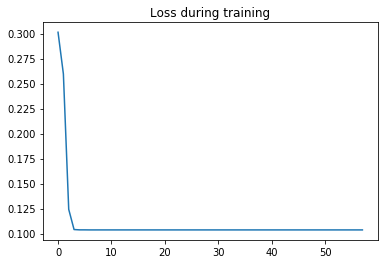

In [37]:
plt.plot(all_loss)
plt.title("Loss during training")

Text(0.5,1,'Comparando resultados do treino(Laranja) com y real (Azul)')

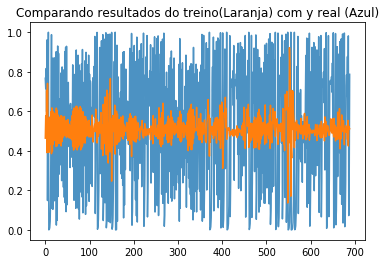

In [38]:
plt.plot(df[:y_train.shape[0]],alpha=0.8)
plt.plot(saida_final)
plt.title("Comparando resultados do treino(Laranja) com y real (Azul)")

In [39]:
def test_network(gating_network,all_experts,X_test,y_test):
    saida_final = output_final(X_test, gating_network, all_experts)
    erro = saida_final - y_test 
    loss = np.square(erro).mean()
    return loss,saida_final

In [40]:
loss,saida_test = test_network(gating_network,all_experts,X_test,y_test)

In [41]:
print("MSE test set {}".format(loss))

MSE test set 0.08508988406194175


Text(0.5,1,'Comparando resultado predicoes teste (Laranja) com y teste real(azul)')

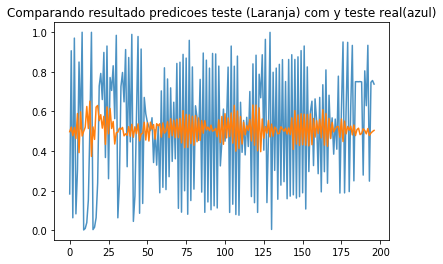

In [43]:
plt.plot(y_test,alpha=0.8)
plt.plot(saida_test)
plt.title("Comparando resultado predicoes teste (Laranja) com y teste real(azul)")

In [32]:
def salva_pesos(network,type_net,filename):
    import json
    w = {}
    w["network"] = type_net
    w1 = {}
    w1["shape"] = network.W1.shape
    w1["pesos"] = network.W1.tolist()
    w["W1"] = w1
    
    b1 = {}
    b1["shape"] = network.b1.shape
    b1["pesos"] = network.b1.tolist()
    w["b1"] = b1
    
    w2 = {}
    w2["shape"] = network.W2.shape
    w2["pesos"] = network.W2.tolist()
    w["W2"] = w2
    
    b2 = {}
    b2["shape"] = network.b2.shape
    b2["pesos"] = network.b2.tolist()
    w["b2"] = b2
    
    with open(filename, "wb") as f:
        f.write(json.dumps(w).encode("utf-8"))

def import_network_object(network, filename):
    import pickle
    pickle.dump(network, open(filename, 'wb'))

In [72]:
# #salvando pesos para arquivo final
# salva_pesos(gt_n,'rede_gating', 'pesos_finais/rede_gating')
# #salvando rede para objeto em arquivo
# import_network_object(gating_network, 'redes_exportadas/rede_gating_pickle')

# for i,exp in enumerate(all_experts):
#     #salvando pesos experts
#     salva_pesos(exp,'rede_expert', 'pesos_finais/rede_expert_{}'.format(i))
#     #salvando objetos experts
#     import_network_object(exp, 'redes_exportadas/rede_expert_pickle_{}'.format(i))
    